Here we will build prediction model based on the data produced at the ETL stage. We will compare:
- naive baseline, simply a mean of y_train
- baseline, which will be a linear model based on 1 feature "number_of_panels_total"
- linear model with all the rest features + regularisation 
- linear model with all features + polynomial features + regularisation 
- random forest
- adaboost
- xgboost
- ensamble of best models

In [26]:
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from category_encoders import LeaveOneOutEncoder
from category_encoders.cat_boost import CatBoostEncoder

from sklearn import linear_model
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, QuantileTransformer, OrdinalEncoder
from sklearn.model_selection import cross_validate, train_test_split, RepeatedKFold, KFold
from sklearn.feature_selection import RFE

# Data initiation

In [2]:
raw_df =  pd.read_csv('datasets/geo_solar_panels.csv').dropna().reset_index(drop=True) # raw df without any additional feats
prescaled_df = pd.read_csv('datasets/prescaled_modeling_df.csv')# eda feats before manual scaling

In [3]:
# constants
label = 'potential_kwh_total'

prescaled_cat_features = [
    'is_usa',
    # 'state',
    'approx_zips'
]

raw_cat_features = [
    'state'
]

prescaled_numeric_features = [col for col in prescaled_df if col!=label and col not in prescaled_cat_features]
raw_numeric_features = [col for col in raw_df if col!=label and col not in raw_cat_features]

# Experiment classes

In [24]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):       
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # self.cols = list(X)
        return self
    
    def transform(self, X):
        """Method transforms the type of the columns of passed dataset into category dtype"""
        return X.astype('category')
    
    def get_feature_names_out(self, input_features=None):
        return input_features
    
def set_up_pipeline(numeric_features: list[str], 
                    categorical_features: list[str], 
                    estimator=ElasticNet(alpha=.001, tol=1e-3),
                    cat_encoder = OrdinalEncoder(),
                    poly_power=1,
                    include_feat_selector=False,
                    n_features_to_select=200):
    """Function that creates data preprocessing pipeline with the passed estimator at the end"""

    pca_pipe = Pipeline(steps=[
        ("scaler", StandardScaler()), 
        ('pca', PCA(n_components=int(len(numeric_features) / 2)))
        ]
    )

    numeric_union = FeatureUnion(transformer_list=[
        ("binariser", QuantileTransformer()),
        ("original", ColumnTransformer([], remainder = 'passthrough')), # done to retreive column names
        ('pca', pca_pipe)
    ])
    
    numeric_transformer = Pipeline(steps=[
        ('numeric_union', numeric_union),
        ('poly', PolynomialFeatures(degree=poly_power)),
        ('scaler', StandardScaler()),
        ]
    )
    
    categorical_transformer = Pipeline(
        steps=[('CategoryTransformer', CategoricalTransformer()), 
               ('encoder', cat_encoder)]  #LeaveOneOutEncoder OrdinalEncoder CatBoostEncoder()
    )

    all_feats_transform = ColumnTransformer(
        transformers=[
            ('numeric_transformer', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
        ]
    )

    fin_steps = [
        ('preprocessor', all_feats_transform),
        ('regressor', estimator)
        ]
    
    if include_feat_selector:
        selector = RFE(
            estimator = ElasticNet(alpha=.001, tol=1e-2),
            step=int(n_features_to_select / 6) + 1, # adding 1 to avoid empty step
            n_features_to_select=n_features_to_select
        )
        fin_steps.insert(1, ('rfe', selector))

    X_pipe = Pipeline(steps=fin_steps)
    return TransformedTargetRegressor(regressor=X_pipe, transformer=StandardScaler())


class NaiveEstimator(BaseEstimator):
    """Class used to make prediction by averaging the label on the train set"""
    def fit(self, X_train, Y_train):
        """Training method. X_train is passed to comply to the input requirements of the sklearn...cross_validate function"""
        self.fitted_mean = Y_train.mean()
    
    def transform(self):
        return self
    
    def predict(self, X_test):
        """Inference method"""
        return np.array([self.fitted_mean] * X_test.shape[0])


class Experiment:
    """Class to conduct and score an experiment using passed model, and data"""
    def __init__(self, X: np.ndarray, label: np.ndarray,  pipe):
        self.label = label
        self.pipe = pipe
        self.X = X

    def _score(self, estimator, X_test, y_test):
        """Method to score the passed model on passed data. Only tb used as input to self.run_exp"""
        y_pred = estimator.predict(X_test)
        naive_baseline_rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test))
        return {'nrmse': naive_baseline_rmse / np.std(y_test),
                'r2': r2_score(y_pred=y_pred, y_true=y_test)}

    def run_exp(self):
        """Method to run cross validation """
        kfold = RepeatedKFold(n_splits=5, n_repeats=5)
        test_res = cross_validate(self.pipe, 
                                X=self.X, 
                                y=self.label, 
                                scoring = self._score,
                                cv=kfold,
                                error_score='raise')
        return {'NRMSE': np.median(test_res['test_nrmse']), 'R2': np.median(test_res['test_r2'])}

# Naive baseline

In [14]:
naive_exp = Experiment(X=raw_df[['number_of_panels_total']],
                       label=raw_df[[label]],
                       pipe=Pipeline([('estimator', NaiveEstimator())])
                       )
naive_exp.run_exp()

{'NRMSE': 1.0000219323256752, 'R2': -4.386513237752965e-05}

# Baseline model

## Single feature

In [15]:
naive_exp = Experiment(X=raw_df[['number_of_panels_total']],
                       label=raw_df[[label]],
                       pipe=Pipeline([('estimator', linear_model.LinearRegression())])
                       )
naive_exp.run_exp()

{'NRMSE': 0.1605818805581412, 'R2': 0.9742134596364108}

Baseline model is much better than naive baseline and the error is only about 16% of label std and very high r2 score. It will probably be hard to beat.

## Extended

In [27]:
# whole raw df, transformation of categorical only

all_feats_transform = ColumnTransformer(
    transformers=[
        ('numeric_transformer', make_pipeline('passthrough'), raw_numeric_features),
        ('cat',  Pipeline(steps=[
                    ('CategoryTransformer', CategoryTransformer()), 
                    ('encoder', LeaveOneOutEncoder())] 
                ), raw_cat_features),
    ]
)

pipeline = Pipeline(steps=[('preprocessor', all_feats_transform),
                           ('regressor', linear_model.LinearRegression())])

naive_exp = Experiment(
    X=raw_df[raw_cat_features + raw_numeric_features],
    label=raw_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.12767473747860764, 'R2': 0.9836991594279361}

In [28]:
# whole raw df with added transformed features and scaling

pipeline = set_up_pipeline(numeric_features=raw_numeric_features, 
                           categorical_features=raw_cat_features, 
                           estimator=linear_model.LinearRegression())
naive_exp = Experiment(
    X=raw_df[raw_cat_features + raw_numeric_features],
    label=raw_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.11882868772806637, 'R2': 0.9858797427917996}

In [30]:
# df with added EDA and transformed features and scaling

pipeline = set_up_pipeline(numeric_features=prescaled_numeric_features, 
                           categorical_features=prescaled_cat_features, 
                           estimator=linear_model.LinearRegression())
naive_exp = Experiment(
    X=prescaled_df[prescaled_cat_features + prescaled_numeric_features],
    label=prescaled_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.12178348591658889, 'R2': 0.9851687581199216}

As expected, addition of all the features does not help the model. Regularisation might help.

# Linear model + regularisation

In [31]:
# whole raw df with added transformed features and scaling

pipeline = set_up_pipeline(numeric_features=raw_numeric_features, 
                           categorical_features=raw_cat_features)
naive_exp = Experiment(
    X=raw_df[raw_cat_features + raw_numeric_features],
    label=raw_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.11974251242476502, 'R2': 0.9856617210743561}

In [32]:
# df with added EDA and transformed features and scaling

pipeline = set_up_pipeline(numeric_features=prescaled_numeric_features, 
                           categorical_features=prescaled_cat_features)
naive_exp = Experiment(
    X=prescaled_df[prescaled_cat_features + prescaled_numeric_features],
    label=prescaled_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.12104166171257366, 'R2': 0.9853489056560505}

regularisation doesn't help with the given number of features. Let's increase the train set by adding polynomial features.

# Linear model + regularisation + polinomial features

In [40]:
# whole raw df with added transformed features and scaling

pipeline = set_up_pipeline(numeric_features=raw_numeric_features, 
                           categorical_features=raw_cat_features,
                           poly_power=2)
naive_exp = Experiment(
    X=raw_df[raw_cat_features + raw_numeric_features],
    label=raw_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.0632661722815773, 'R2': 0.9959973884292026}

In [41]:
# df with added EDA and transformed features and scaling

pipeline = set_up_pipeline(numeric_features=prescaled_numeric_features, 
                           categorical_features=prescaled_cat_features,
                           poly_power=2)
naive_exp = Experiment(
    X=prescaled_df[prescaled_cat_features + prescaled_numeric_features],
    label=prescaled_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.062408029898667054, 'R2': 0.9961052262028762}

Score is improved by adding polinomial features. Let's look at the feature importance graph

In [ ]:
X = prescaled_df[prescaled_cat_features + prescaled_numeric_features]; y = prescaled_df[[label]]
pipeline.regressor_['preprocessor'].fit_transform(X, y).shape

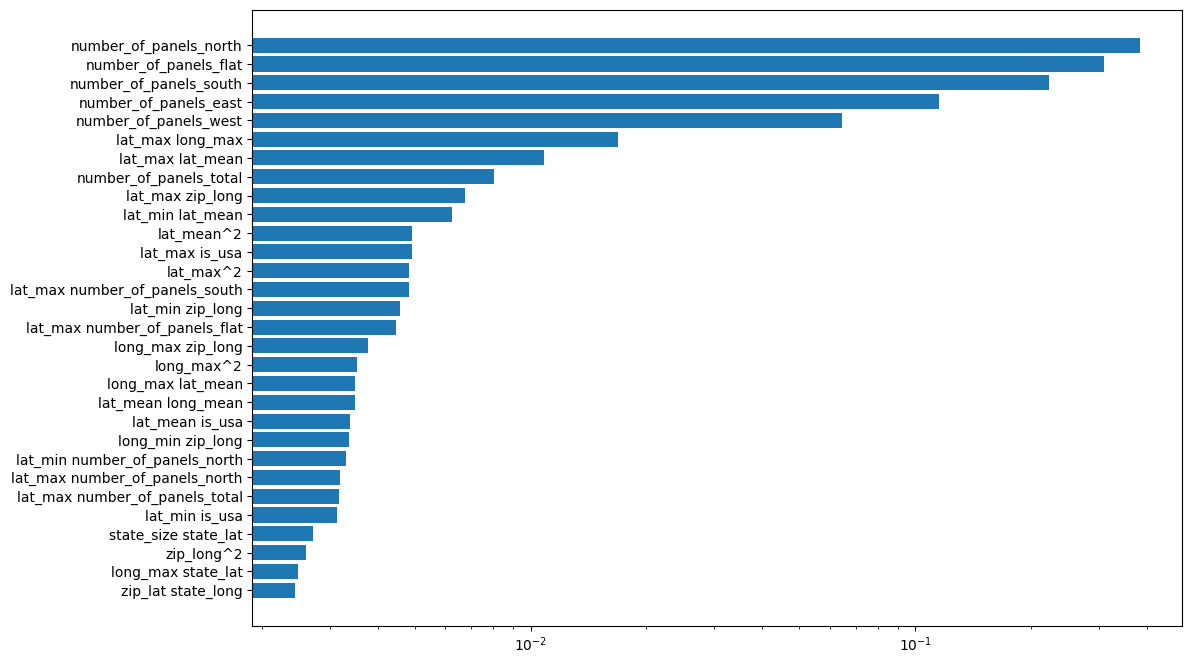

In [ ]:
plt.figure(figsize=[12,8])
feat_imp_df = pd.DataFrame(zip(poly.get_feature_names_out(), baseline_model.coef_)).set_index(0).abs().sort_values(1, ascending=False)[:30].sort_values(1)
plt.barh(feat_imp_df.index, feat_imp_df[1])
plt.xscale('log')

# Extreme gradient boosting

## XGBoost params optimisation

In [6]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1200),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 7.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 7.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    xgb = XGBRegressor(**params)
    regr = set_up_pipeline(numeric_features=prescaled_numeric_features, 
                        categorical_features=prescaled_cat_features,
                        poly_power=2,
                        estimator=xgb)


    X = prescaled_df[prescaled_numeric_features + prescaled_cat_features]
    y = prescaled_df[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)

    return np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test)) / np.std(y_test)

study = optuna.create_study(direction='minimize', study_name='regression4')
study.optimize(objective, n_trials=500)
print('Best parameters', study.best_params)

[I 2023-04-24 15:43:05,616] A new study created in memory with name: regression4
[I 2023-04-24 15:43:57,985] Trial 0 finished with value: 0.0876532317355358 and parameters: {'max_depth': 3, 'learning_rate': 0.34902551657649195, 'n_estimators': 61, 'gamma': 0.790182800872691, 'reg_alpha': 1.7034553215588106, 'reg_lambda': 6.231083206594394, 'colsample_bytree': 0.5259642566895333}. Best is trial 0 with value: 0.0876532317355358.
[I 2023-04-24 15:44:21,118] Trial 95 finished with value: 0.05757316733375041 and parameters: {'max_depth': 6, 'learning_rate': 0.012867992423479848, 'n_estimators': 1148, 'gamma': 0.17702719934688255, 'reg_alpha': 1.0376391754346987, 'reg_lambda': 0.3093718024361968, 'colsample_bytree': 0.8197049100003628}. Best is trial 86 with value: 0.04178580986276814.
[I 2023-04-24 15:49:20,905] Trial 1 finished with value: 0.11221072046012605 and parameters: {'max_depth': 1, 'learning_rate': 0.3320286429381744, 'n_estimators': 1131, 'gamma': 0.3816578258656203, 'reg_alpha'

KeyboardInterrupt: 

In [7]:
best_params = {'max_depth': 7, 'learning_rate': 0.11786823314440668, 'n_estimators': 947, 'gamma': 0.1130538494937697, 
               'reg_alpha': 1.0147456773700723, 'reg_lambda': 1.    , 'colsample_bytree': 0.8078136810830938}

xgb = XGBRegressor(**best_params)#
regr = set_up_pipeline(numeric_features=prescaled_numeric_features, 
                    categorical_features=prescaled_cat_features,
                    poly_power=2,
                    estimator=xgb)


X = prescaled_df[prescaled_numeric_features + prescaled_cat_features]
y = prescaled_df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print(np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test)) / np.std(y_test))

0.050928908394293614


In [21]:
#reconfirming result on repeated cross validation
xgb = XGBRegressor(**best_params)#
pipeline = set_up_pipeline(numeric_features=prescaled_numeric_features, 
                           categorical_features=prescaled_cat_features,
                           poly_power=2,
                           estimator=xgb)
naive_exp = Experiment(
    X=prescaled_df[prescaled_cat_features + prescaled_numeric_features],
    label=prescaled_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.05257058548281622, 'R2': 0.9972363335419939}

## XGB with feature selector

In [23]:
#
xgb = XGBRegressor(**best_params)#
pipeline = set_up_pipeline(numeric_features=prescaled_numeric_features, 
                           categorical_features=prescaled_cat_features,
                           poly_power=2,
                           estimator=xgb,
                           include_feat_selector=True,
                           n_features_to_select=500) # optimal number of features selected in pathfinder notebook
naive_exp = Experiment(
    X=prescaled_df[prescaled_cat_features + prescaled_numeric_features],
    label=prescaled_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.057550216871569713, 'R2': 0.9966879725380353}

## XGB with catboost categorical encoder

In [27]:
xgb = XGBRegressor(**best_params)#
pipeline = set_up_pipeline(numeric_features=prescaled_numeric_features, 
                           categorical_features=prescaled_cat_features,
                           cat_encoder = CatBoostEncoder(),
                           poly_power=2,
                           estimator=xgb)
naive_exp = Experiment(
    X=prescaled_df[prescaled_cat_features + prescaled_numeric_features],
    label=prescaled_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.05577823520667444, 'R2': 0.996888788477229}

## 3-rd degree polynomial

In [35]:
xgb = XGBRegressor(**best_params)
    
pipeline = set_up_pipeline(numeric_features=prescaled_numeric_features, 
                           categorical_features=prescaled_cat_features,
                           poly_power=3,
                           estimator=xgb)

naive_exp = Experiment(
    X=prescaled_df[prescaled_cat_features + prescaled_numeric_features],
    label=prescaled_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

{'NRMSE': 0.06033089045572171, 'R2': 0.9963601836568197}

# Catboost

In [29]:
!pipenv install catboost

Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.
Installing catboost...
Adding catboost to Pipfile's [packages]...
✔ Installation Succeeded 
Pipfile.lock not found, creating...
Locking [packages] dependencies...
Building requirements...
Resolving dependencies...
✔ Success! 
Locking [dev-packages] dependencies...
Updated Pipfile.lock (719fb691139cde367f4f79a9efcb9822e902e269e51ce7058d862bed66896353)!
Installing dependencies from Pipfile.lock (896353)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


In [34]:
from catboost import CatBoostRegressor

ctb = CatBoostRegressor()
pipeline = set_up_pipeline(numeric_features=prescaled_numeric_features, 
                           categorical_features=prescaled_cat_features,
                           poly_power=2,
                           cat_encoder='passthrough',
                           estimator=ctb)

naive_exp = Experiment(
    X=prescaled_df[prescaled_cat_features + prescaled_numeric_features],
    label=prescaled_df[[label]],
    pipe=pipeline
)

naive_exp.run_exp()

Learning rate set to 0.05813
0:	learn: 0.9487489	total: 161ms	remaining: 2m 40s
1:	learn: 0.9001350	total: 226ms	remaining: 1m 52s
2:	learn: 0.8532059	total: 279ms	remaining: 1m 32s
3:	learn: 0.8091905	total: 331ms	remaining: 1m 22s
4:	learn: 0.7676050	total: 383ms	remaining: 1m 16s
5:	learn: 0.7308865	total: 433ms	remaining: 1m 11s
6:	learn: 0.6937082	total: 486ms	remaining: 1m 8s
7:	learn: 0.6587373	total: 536ms	remaining: 1m 6s
8:	learn: 0.6257807	total: 586ms	remaining: 1m 4s
9:	learn: 0.5939742	total: 634ms	remaining: 1m 2s
10:	learn: 0.5648926	total: 685ms	remaining: 1m 1s
11:	learn: 0.5379428	total: 737ms	remaining: 1m
12:	learn: 0.5115421	total: 786ms	remaining: 59.7s
13:	learn: 0.4866735	total: 834ms	remaining: 58.8s
14:	learn: 0.4633671	total: 886ms	remaining: 58.2s
15:	learn: 0.4410703	total: 937ms	remaining: 57.6s
16:	learn: 0.4196962	total: 987ms	remaining: 57.1s
17:	learn: 0.3995534	total: 1.03s	remaining: 56.5s
18:	learn: 0.3803881	total: 1.08s	remaining: 56s
19:	learn: 

{'NRMSE': 0.044907257671024055, 'R2': 0.9979833382084683}